<a href="https://colab.research.google.com/github/KSY1526/SSUDA_LOTTEs/blob/main/Daniel/LPOINT_AE_KMEANS_%EC%98%81%EC%88%98%EC%A6%9D_%EA%B5%B0%EC%A7%91%ED%99%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi
!head /proc/cpuinfo
!head -n 3 /proc/meminfo

Tue Jul 19 07:39:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
from tqdm import tqdm
import pandas as pd
import warnings; warnings.filterwarnings("ignore")
import numpy as np

path = "/content/drive/MyDrive/my_data/LPOINT/"

In [4]:
pdde_cust = pd.read_csv(path+"/LPOINT_BIG_COMP_PDDE_CUST.csv", header=0,encoding="utf-8")

In [5]:
pdde_cust

,Unnamed: 0,cust,ma_fem_dv,ages,zon_hlv,de_dt,de_hr,chnl_dv,br_zon_hlv,br_zon_mcls,cop_c,br_c,clac_hlv_nm,clac_mcls_nm,pd_nm,pd_c,buy_ct,buy_am,rct_no
0,0,M430112881,여성,50대,Z17,20210101,10,1,Z10,Z10042,A01,A010039,남성의류,남성의류상의,남성티셔츠,PD0290,1,15000.0,A01000001113
1,1,M430112881,여성,50대,Z17,20210101,10,1,Z10,Z10042,A01,A010039,남성의류,남성의류상의,남성티셔츠,PD0290,1,19000.0,A01000003148
2,2,M430112881,여성,50대,Z17,20210101,10,1,Z10,Z10042,A01,A010039,남성의류,남성의류상의,남성티셔츠,PD0290,1,19000.0,A01000003148
3,3,M430112881,여성,50대,Z17,20210101,10,1,Z10,Z10042,A01,A010039,남성의류,남성의류상의,남성티셔츠,PD0290,1,19000.0,A01000004946
4,4,M430112881,여성,50대,Z17,20210101,10,1,Z10,Z10042,A01,A010039,테넌트/음식점,식당,커피/음료,PD1692,1,9900.0,A01000005297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4381738,4381738,M498069014,여성,40대,Z14,20211227,16,2,NaN,NaN,A06,NaN,상품권,모바일상품권,백화점/마트모바일상품권,PD0507,1,100000.0,E06052019590
4381739,4381739,M498069014,여성,40대,Z14,20211227,16,2,NaN,NaN,A06,NaN,상품권,모바일상품권,백화점/마트모바일상품권,PD0507,1,100000.0,E06052019590
4381740,4381740,M498069014,여성,40대,Z14,20211227,16,2,NaN,NaN,A06,NaN,상품권,모바일상품권,백화점/마트모바일상품권,PD0507,1,100000.0,E06052019590
4381741,4381741,M498069014,여성,40대,Z14,20211227,16,2,NaN,NaN,A06,NaN,상품권,모바일상품권,백화점/마트모바일상품권,PD0507,1,100000.0,E06052019590


In [ ]:
# 모델 : 영수증 to 고객

# step1. 유사한 영수증 추출
# # 구매중 입력된 영수증과의 "유사도가 높은 최근 한 달 이내 결제된 영수증"을 충분한 크기로 추출(약 300개)

# step2. 유사한 영수증을 가진 고객 추출
# # 추출된 영수증을 가진 고객들을 추출(약 10~60명)

# step3. 그들을 구매중인 고객과의 유사도를 기준으로 정렬
# # 추출된 고객을 구매중인 고객과의 유사도(코사인 유사도 등)를 기준으로 정렬

# step4. 구매중인 고객에게 노출
# # 유사도가 높은 고객 상위 5명을 구매중인 고객에게 노출

In [5]:
test_PC_C_SUMS = pd.read_csv(path+"/LPOINT_BIG_COMP_PC_C_SUMS_8.csv", header=0,encoding="utf-8")

In [9]:
test_PC_C_SUMS.set_index("rct_no", inplace = True)

In [7]:
import torch
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
class CustomDataset(Dataset):

    def __init__(self, x):
        self.xx = x.copy().values.astype(np.float32)

    def __len__(self):
        # 길이 출력
        return len(self.xx)

    def __getitem__(self, idx):
        # 특정 1개 샘플 가져오는 곳
        return self.xx[idx]

In [12]:
datas = CustomDataset(test_PC_C_SUMS)
dataL = DataLoader(datas, batch_size = 32)

In [18]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(1933, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.BatchNorm1d(10),
            nn.ReLU()
        )
    
        self.decoder = nn.Sequential(
            nn.Linear(10,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64,512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1933), #처음 입력된 크기와 같은 크기로 나와야 한다 
            #nn.Sigmoid()
        )
    
  #인코더와 디코더 연산을 차례대로 수행하도록 설정 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

In [19]:
model = Autoencoder().to(device)
critertion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [20]:
for epoch in range(3):
    running_loss = 0
    for data in dataL:
        inputs = data.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)[0]#.view(-1, 3820)) #이미지를 일렬로 펴서 넣기 
        #outputs = outputs.view(-1, 1, 28, 28) #나온 이미지를 다시 정가각형 형태로 변환 
        loss = critertion(inputs, outputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    cost = running_loss / len(dataL)
    print('[%d] loss : %.3f' %(epoch +1, cost))

[1] loss : 0.022
[2] loss : 0.017
[3] loss : 0.016


In [26]:
torch.tensor(test_PC_C_SUMS.to_numpy(), dtype=torch.float32)

tensor(617276.)

In [29]:
with torch.no_grad():
    temT = torch.from_numpy(test_PC_C_SUMS.to_numpy()).to(device, dtype=torch.float32)
    decoders, encoders = model(temT)
    encoders

In [32]:
summarys = pd.DataFrame(encoders.cpu().numpy())
summarys.head(10)

,0,1,2,3,4,5,6,7,8,9
0,0.359313,0.000000,0.583578,0.380244,0.000000,0.516933,0.488912,0.527413,0.000000,0.371171
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.521815,0.000000
2,0.000000,0.293385,0.000000,0.000000,0.524679,0.000000,0.000000,0.000000,0.111725,0.000000
3,0.620108,0.000000,0.877698,0.798076,0.000000,0.776015,0.794277,0.711164,0.000000,0.615905
4,1.368329,0.000000,1.921201,2.016083,0.000000,1.620319,0.482006,2.189893,0.000000,1.374157
5,1.001782,0.000000,0.910185,0.577820,0.000000,0.714968,1.048162,0.910767,0.000000,0.611074
6,2.149601,0.000000,1.900857,1.407674,0.000000,1.936324,1.718551,1.714048,0.000000,1.484590
7,0.000000,0.147525,0.022622,0.000000,0.213867,0.000000,0.000000,0.138890,0.053427,0.000000
8,0.000000,0.000000,0.000000,0.005085,0.000000,0.000000,0.000000,0.101831,0.551523,0.026024
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.533081,0.000000


In [34]:
summarys.shape

(86019, 10)

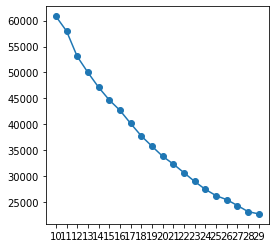

In [35]:
from sklearn.cluster import KMeans
# 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(10,30,1)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(summarys)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xticks(ks)
plt.show()

In [36]:
clust_model = KMeans(n_clusters = 10)
clust_model.fit(summarys)
pred = clust_model.predict(summarys)
pred[:10]

array([5, 0, 0, 5, 2, 2, 3, 0, 0, 0], dtype=int32)

In [37]:
test_PC_C_SUMS['pred'] = pred
test_PC_C_SUMS['pred'].value_counts()

0    67445
5     8458
2     5293
3     2881
1     1233
8      439
7      143
6       72
9       52
4        3
Name: pred, dtype: int64

https://www.dlology.com/blog/how-to-do-unsupervised-clustering-with-keras/